In [1]:
# library imports
from io import BytesIO
from zipfile import ZipFile

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import statsmodels.api as sm
from scipy.stats import spearmanr, pearsonr, kendalltau, stats
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, roc_curve, roc_auc_score, 
                             precision_recall_curve, auc, classification_report, 
                             brier_score_loss, f1_score)
from sklearn.calibration import calibration_curve
from imblearn.over_sampling import SMOTE

# Constants and settings
SEED = 23
plt.style.use('dark_background')
pd.set_option('display.max_columns', None)


In [2]:
def download_df(file_url):    
    try:
        response = requests.get(file_url)
        # Check if the request was successful
        if response.status_code == 200:
            # Open the response content as bytes
            with ZipFile(BytesIO(response.content)) as thezip:
                # Get a list of all archived file names from the zip
                all_files = thezip.namelist()
                # Find the first CSV file in the ZIP archive
                csv_file_name = next((s for s in all_files if ".csv" in s), None)
                if csv_file_name is not None:
                    # Open the CSV file within the zipfile
                    with thezip.open(csv_file_name) as csv_file:
                        df = pd.read_csv(csv_file)
                        display(df.head())
                        return df
                else:
                    print("No CSV file found in the ZIP archive.")
                    return None
        else:
            print('Failed to download the file: Status code', response.status_code)
            return None
    except Exception as e:
        print(f'An error occurred: {e}')
        return None


In [3]:
def Standard_Outlier_Remover(df_source, num_cols, num_std=3): 
    """
    Remove outliers from specified numeric columns in a DataFrame.
    
    Parameters:
    -----------
    df_source : pandas DataFrame
        The original DataFrame from which to remove outliers.
    num_cols : list of str
        List of column names in df_source that are numeric and should be checked for outliers.
    num_std : int or float, optional
        The number of standard deviations to use for defining outliers. Default is 3.
        
    Returns:
    --------
    df_win : pandas DataFrame
        A new DataFrame with outliers removed.
    ratio : float
        The percentage of observations in the original DataFrame that were identified as outliers.
    outliers : list of int
        List of row indices in the original DataFrame that were identified as outliers.
    """
    
    df = df_source.copy()
    
    outliers = []
    
    for col in num_cols:
        mean = df[col].mean()
        std = df[col].std()
        tol = num_std * std
        upper = mean + tol
        lower = mean - tol
        
        # Using vectorized operations to find outliers
        outlier_mask = (df[col] > upper) | (df[col] < lower)
        outliers.extend(df.index[outlier_mask])
        
    # Remove duplicates
    outliers = list(set(outliers))
    
    # Calculate ratio of outliers
    ratio = round(len(outliers) / len(df) * 100, 2)
    
    # Drop outliers
    df_win = df.drop(index=outliers)
    
    return df_win, ratio, outliers

In [4]:
def Winsorization_Method(df_source, columns,  lower, upper):
    """
    Remove outliers from the given DataFrame based on the provided lower and upper percentiles.

    Parameters:
    -----------
    df_source : pandas.DataFrame
        The original DataFrame from which outliers will be removed.
    columns : list of str
        The names of the columns to consider for outlier removal.
    lower : float
        The lower percentile below which data points are considered as outliers.
    upper : float
        The upper percentile above which data points are considered as outliers.

    Returns:
    --------
    ratio : float
        The ratio of outliers in the original DataFrame, rounded to two decimal places.
    df_win : pandas.DataFrame
        A new DataFrame with the outliers removed.
    
    Example:
    --------
    >>> ratio, df_win = Winsorization_Method(df, ['A', 'B'], 10, 90)
    
    Notes:
    ------
    - The function makes a copy of the original DataFrame, so the original DataFrame remains unchanged.
    - Outliers are determined separately for each column and are not considered across multiple columns.

    """
    #Data preparation
    df = df_source.copy()
    df = df[columns]

    #Determining records with outliers
    outliers=[]
    
    for col in columns:
        q1 = np.percentile(df[col], lower)
        q2 = np.percentile(df[col], upper)
        
        for pos in range(len(df)):
            if df[col].iloc[pos]>q2 or df[col].iloc[pos]<q1:
                outliers.append(pos) 
                
    outliers = set(outliers)                   
    outliers = list(outliers)
    
    ratio= round(len(outliers)/len(df)*100, 2) #calculating the ratio of outliers in the original data                     
    df_win = df.drop(df.index[outliers]) 
    
    return ratio, df_win

In [5]:
def heatmap_spearman_significance(df, annot=True):
    """
    Generate a heatmap displaying the Spearman's rank correlation coefficients 
    for each pair of variables in the provided DataFrame. If annot is True, 
    p-values and significance levels are annotated within each cell. Also, 
    return a DataFrame with the Spearman's rank correlation coefficients and 
    p-values for each pair of variables.

    Parameters:
    df (DataFrame): A pandas DataFrame containing the variables for which correlations 
                    are to be calculated. The DataFrame should contain only numeric 
                    columns.
    annot (bool): If True, display p-values and significance levels in the heatmap. 
                  Default is True.

    Returns:
    DataFrame: A DataFrame containing the Spearman's rank correlation coefficients and 
               p-values for each pair of variables.
    """
    # Initialize matrices
    correlations = df.corr(method='spearman')
    annotations = pd.DataFrame(index=df.columns, columns=df.columns)
    results = []

    # Calculate Spearman correlation and p-values, format annotations
    for col1 in df.columns:
        for col2 in df.columns:
            if col1 != col2:
                corr, p_val = stats.spearmanr(df[col1].dropna(), df[col2].dropna())
                # Determine the significance level
                if p_val < 0.01:
                    sig = '***'
                elif p_val < 0.05:
                    sig = '**'
                elif p_val < 0.1:
                    sig = '*'
                else:
                    sig = ''
                # Format annotation with correlation and p-value
                annotations.at[col1, col2] = f'{corr:.2f}\n({p_val:.3f}){sig}'
                # Append results to list
                results.append({'Pair': f'{col1}-{col2}', 'Correlation': corr, 'P-value': p_val})
            else:
                annotations.at[col1, col2] = ''

    # Create a mask for the upper triangle
    mask = np.triu(np.ones_like(correlations, dtype=bool))

    # Plot heatmap
    plt.figure(figsize=(10, 8))
    if annot:
        sns.heatmap(correlations, annot=annotations, mask=mask, cmap='coolwarm', fmt='', cbar_kws={'label': 'Spearman Correlation Coefficient'})
    else:
        sns.heatmap(correlations, annot=False, mask=mask, cmap='coolwarm', cbar_kws={'label': 'Spearman Correlation Coefficient'})
    plt.title("Spearman's Rank Correlation Heatmap" + (" with P-value and Significance Annotations" if annot else ""))
    plt.show()

    # Convert results list to DataFrame and return
    results_df = pd.DataFrame(results)
    return results_df.set_index('Pair')

In [6]:
def high_corr(df_source, method='spearman', thsld=0.8, p_val_tshld = 0.05):
    """
    Remove columns from a DataFrame that are highly correlated with other columns,
    considering p-values for determining the significance of correlations.

    Parameters:
    -----------
    df_source : pandas.DataFrame
        The original DataFrame for which to identify and remove highly correlated columns.

    method : str, optional
        The correlation method to be used. 'pearson', 'kendall', 'spearman' are supported. 
        Default is 'spearman'.

    thsld : float, optional
        The absolute correlation threshold. Pairs of columns with correlation higher than this value 
        will be considered for removal. Default is 0.8.

    Returns:
    --------
    df : pandas.DataFrame
        A new DataFrame with highly correlated columns removed, considering p-values and correlation counts.
    """
    df = df_source.copy()
    cols = df.columns
    corr_counts = {col: 0 for col in cols}  # Initialize correlation counts
    mean_corrs = {col: [] for col in cols}  # Initialize list to store significant correlations for mean calculation
    pairs = []
    
    # Calculate correlation and p-value for each pair of variables
    for i in range(len(cols)):
        for j in range(i):
            if cols[i] != cols[j]:
                if method == 'spearman':
                    corr, p_val = spearmanr(df[cols[i]].dropna(), df[cols[j]].dropna())
                elif method == 'pearson':
                    corr, p_val = pearsonr(df[cols[i]].dropna(), df[cols[j]].dropna())
                elif method == 'kendall':
                    corr, p_val = kendalltau(df[cols[i]].dropna(), df[cols[j]].dropna())
                else:
                    raise ValueError("method must be 'spearman', 'pearson', or 'kendall'")
                
                # Check if correlation is high and significant
                if abs(corr) > thsld and p_val < p_val_tshld:
                    corr_counts[cols[i]] += 1
                    corr_counts[cols[j]] += 1
                    mean_corrs[cols[i]].append(abs(corr))
                    mean_corrs[cols[j]].append(abs(corr))
                    pairs.append([cols[i], cols[j]])
    
    # Calculate means outside the loop to avoid repeated calculations
    mean_corrs_avg = {col: np.mean(mean_corrs[col]) for col in mean_corrs}

    to_remove = set()
    for col_1, col_2 in pairs:
        if corr_counts[col_1] > 1 and corr_counts[col_2] > 1:
            # If both columns have the same number of high correlations
            if corr_counts[col_1] == corr_counts[col_2]:
                if mean_corrs_avg[col_1] > mean_corrs_avg[col_2]:
                    to_remove.add(col_1)
                elif mean_corrs_avg[col_1] < mean_corrs_avg[col_2]:
                    to_remove.add(col_2)
            # If the number of high correlations is different
            else:
                if corr_counts[col_1] > corr_counts[col_2]:
                    to_remove.add(col_1)
                elif corr_counts[col_1] < corr_counts[col_2]:
                    to_remove.add(col_2)
    return to_remove

In [7]:
def grid_log_c(X_train, y_train, X_test, y_test, C_values, penalty='l1', solver = 'liblinear', random_state=23):
    """
    Evaluates and plots the train and test accuracy of a logistic regression model for various C values.

    Parameters:
    -----------
    X_train : array-like or DataFrame
        The features for the training set.
    y_train : array-like or DataFrame
        The target variable for the training set.
    X_test : array-like or DataFrame
        The features for the test set.
    y_test : array-like or DataFrame
        The target variable for the test set.
    C_values : list of floats
        The list of C values to evaluate. C is the inverse regularization strength.
    penalty : str, optional
        The penalty type to use in the logistic regression model ('l1' or 'l2'). Default is 'l1'.
    solver: str, optional
        Algorithm to use in the optimization problem. Default is ‘liblinear’.
    random_state : int, optional
        The number used to initialize a pseudorandom number generator, which is used for reproducibility of the results.

    Returns:
    --------
    train_accuracies : list of floats
        The train accuracies for the different C values.
    test_accuracies : list of floats
        The test accuracies for the different C values.
    
    Notes:
    ------
    - This function uses a log scale for the C values on the x-axis of the plot.

    Example:
    --------
    >>> C_values = [0.001, 0.01, 0.1, 1, 10]
    >>> grid_log_c(X_train, y_train, X_test, y_test, C_values, 32)

    """
    train_accuracies = []
    test_accuracies = []

    # Implement a model
    for c in C_values:
        lr = LogisticRegression(C=c, solver=solver, penalty=penalty, random_state=random_state)
        lr.fit(X_train, y_train)

        train_accuracy = lr.score(X_train, y_train)
        test_accuracy = lr.score(X_test, y_test)

        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)

    # Draw a plot
    plt.figure(figsize=(10, 6))
    plt.plot(C_values, train_accuracies, label='Train Accuracy', marker='o')
    plt.plot(C_values, test_accuracies, label='Test Accuracy', marker='^')
    plt.xscale('log')
    plt.xlabel('C Value (log scale)')
    plt.ylabel('Accuracy')
    plt.title('Train and Test Accuracy for Different C Values')
    plt.legend()
    plt.show()

    return train_accuracies, test_accuracies

In [8]:
def plot_grid_search(cv_results, grid_params):
    """
    Plots the test scores from a Grid Search as either a line plot or heatmap based on the number of hyperparameters.

    Parameters:
    -----------
    cv_results : dict
        A dictionary of cross-validation results, usually obtained from `GridSearchCV.cv_results_`.
    
    grid_params : list of str
        A list of hyperparameter names that are part of the grid search.

    Returns:
    --------
    None

    Notes:
    ------
    - If there's only one hyperparameter, the function will plot a line plot.
    - If there are two hyperparameters, the function will plot a heatmap.
    - If there are more than two hyperparameters, the function will print a message indicating its limitation.
    
    Example:
    --------
    >>> plot_grid_search(cv_results, ['param1', 'param2'])
    [Heatmap is displayed]

    >>> plot_grid_search(cv_results, ['param1'])
    [Line plot is displayed]
    """
    #Convert to DataFrame
    results = pd.DataFrame(cv_results)

    # If only one hyperparameter, plot a line plot
    if len(grid_params) == 1:
        param = 'param_' + grid_params[0]
        plt.figure(figsize=(8, 6))
        plt.plot(results[param], results['mean_test_score'], marker='o')
        plt.xlabel(grid_params[0])
        plt.ylabel('Mean Test Score')
        plt.title(f"Grid Search Test Scores")
        plt.show()
    
    # If two hyperparameters, plot a heatmap
    elif len(grid_params) == 2:
        pivot_table = results.pivot(index=f'param_{grid_params[0]}', 
                                    columns=f'param_{grid_params[1]}', 
                                    values='mean_test_score')
        sns.heatmap(pivot_table, annot=True, cmap='coolwarm')
        plt.xlabel(grid_params[1])
        plt.ylabel(grid_params[0])
        plt.title(f"Grid Search Test Score Heatmap")
        plt.show()

    # For more than two hyperparameters, print a message
    else:
        print("The function is designed to plot up to two hyperparameters.")

In [9]:
def feature_importance_logreg(classifier, X_train, y_train, cut_off=0.05):
    
    """
    Plots feature importances for a logistic regression model using L1 regularisation.

    Parameters:
    ----------
    classifier : sklearn.linear_model object
        The logistic regression model. 
    X_train : array-like or DataFrame
        The features for the training set.
    y_train : array-like or DataFrame
        The target variable for the training set. 
    cut_off : float, optional
        The cut-off value to consider for feature importance.

    Returns:
    -------
    feature_df : pandas DataFrame
        A DataFrame containing the features sorted by their importance.
        
    omitted_df : pandas DataFrame
        A DataFrame containing the features that were omitted based on the cut-off value.
    """
    # Create the model
    classifier.fit(X_train, y_train)
    
    # Get feature importances
    feature_importance_values = np.abs(classifier.coef_)
    
    # Sort feature importances
    indices = np.argsort(feature_importance_values[0])[::-1]
    
    sorted_feature_names = [X_train.columns[i] for i in indices]
    sorted_importance_values = [feature_importance_values[0][i] for i in indices]
    
    # Apply cutoff if specified
    if cut_off is not None:
        omitted_feature_names = [name for i, name in enumerate(sorted_feature_names) if sorted_importance_values[i] < cut_off]
        omitted_importance_values = [value for value in sorted_importance_values if value < cut_off]
        
        sorted_feature_names = [name for name in sorted_feature_names if name not in omitted_feature_names]
        sorted_importance_values = [value for value in sorted_importance_values if value >= cut_off]
    
    # Plot feature importances
    plt.figure(figsize=(12, 6))
    plt.title("Feature Importance")
    plt.bar(range(len(sorted_importance_values)), sorted_importance_values, align="center")
    plt.xticks(range(len(sorted_importance_values)), sorted_feature_names, rotation=90)  # Add rotation for better visibility
    plt.xlabel("Feature Name")
    plt.ylabel("Absolute Coefficient Value")
    plt.show()
    
    # Create a DataFrame for sorted feature importances
    feature_df = pd.DataFrame({
        'Feature': sorted_feature_names,
        'Importance': sorted_importance_values
    })
    
    # Create a DataFrame for omitted feature importances
    omitted_df = pd.DataFrame({
        'Omitted Feature': omitted_feature_names,
        'Omitted Importance': omitted_importance_values
    })
    
    return feature_df, omitted_df

In [10]:
def plot_omitted_accuracy(classifier, X_train, y_train, X_test, y_test, high_pvalues, low_imp_df, SEED=42):
    """
    Plots the train and test accuracy of a Logistic Regression model when omitting certain variables.
    Performs this operation with and without replacement.

    Parameters:
    -----------
    classifier : sklearn.linear_model object
        The logistic regression model. 
    X_train, y_train : Training data and labels
    X_test, y_test : Test data and labels
    high_pvalues : list of features to be omitted based on high p-values
    low_imp_df : DataFrame containing features to be omitted based on low importance
    SEED : random state seed for reproducibility

    Returns:
    --------
    acc_df : DataFrame containing train and test accuracies

    """
    fig, axs = plt.subplots(1, 2, figsize=(24, 6))

    # Omitting variables with replacement
    to_delete = set(high_pvalues + low_imp_df['Omitted Feature'].to_list())
    acc_dict = {}
    for var in to_delete:
        X_train_fe = X_train.copy()
        X_train_fe.drop(columns=var, inplace=True)
        classifier.fit(X_train_fe, y_train)
        train_score = classifier.score(X_train_fe, y_train)
        y_pred_fe = classifier.predict(X_test_final[X_train_fe.columns])
        test_score = accuracy_score(y_pred_fe, y_test)
        acc_dict[var] = [train_score, test_score]
    acc_df = pd.DataFrame(acc_dict).transpose()
    acc_df.columns = ['train_acc', 'test_acc']
    
    # Creating a lineplot 0
    acc_df.plot(ax=axs[0], title='With Replacement')
    axs[0].set_xticks(np.arange(len(acc_df.index)))
    axs[0].set_xticklabels(acc_df.index, rotation=90)

    # Omitting variables without replacement
    to_delete = list(acc_df.sort_values('test_acc', ascending=False).index)
    acc_dict = {}
    X_train_fe = X_train.copy()
    for var in to_delete:
        X_train_fe.drop(columns=var, inplace=True)
        classifier.fit(X_train_fe, y_train)
        train_score = classifier.score(X_train_fe, y_train)
        y_pred_fe = classifier.predict(X_test_final[X_train_fe.columns])
        test_score = accuracy_score(y_pred_fe, y_test)
        acc_dict[var] = [train_score, test_score]
    acc_df = pd.DataFrame(acc_dict).transpose()
    acc_df.columns = ['train_acc', 'test_acc']
    
    # Creating the list of omitted variables
    acc_delete = []
    # Finding the last occurrence of the max test accuracy
    max_test_acc = acc_df['test_acc'].max()
    last_max_nm = acc_df[::-1]['test_acc'].idxmax()
    last_max_index = acc_df.index.get_loc(last_max_nm)

    for var in acc_df.index:
        if var != last_max_nm:
            acc_delete.append(var)
        else: 
            break
        
    # Creating a lineplot 1
    acc_df.plot(ax=axs[1], title='Without Replacement')
    axs[1].set_xticks(np.arange(len(acc_df.index)))
    axs[1].set_xticklabels(acc_df.index, rotation=90)
    axs[1].axvline(last_max_index, color='red', linestyle='--', label='Max Test Accuracy')
    axs[1].legend()
    plt.show()
        
    return acc_df, acc_delete

In [11]:
def plot_roc(X, y, classifier, n_splits):
    """
    Plots the Receiver Operating Characteristic (ROC) curve using Stratified K-Fold cross-validation.

    Parameters:
    -----------
    X_train : pandas DataFrame
        The feature matrix for the training set.
    y_train : pandas Series
        The target vector for the training set.
    classifier : scikit-learn classifier object
        A fitted classifier that has a `predict_proba` method.
    n_splits : int
        The number of folds for Stratified K-Fold cross-validation.

    Returns:
    --------
    [The ROC curves from each fold as well as the mean and +/- 1 std. dev. are plotted.]

    Notes:
    ------
    - The AUC (Area Under the Curve) for each fold is also displayed.
    """
    
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=123)
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots()

    for i, (train_idx, test_idx) in enumerate(skf.split(X, y)):
        classifier.fit(X.iloc[train_idx], y.iloc[train_idx])  # Use iloc for DataFrame

        # Compute ROC values
        fpr, tpr, _ = roc_curve(y.iloc[test_idx], classifier.predict_proba(X.iloc[test_idx])[:,1])
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        ax.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc), lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label=r'$\pm$ 1 std. dev.')

    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05], title="Receiver operating characteristic",xlabel = 'False Positive Rate',
          ylabel = 'True Positive Rate')
    ax.legend(loc="lower right")
    plt.show()

# Data import and transformation

In [12]:
df = download_df('https://archive.ics.uci.edu/static/public/572/taiwanese+bankruptcy+prediction.zip')

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan ¥),Operating Profit Per Share (Yuan ¥),Per Share Net profit before tax (Yuan ¥),Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Regular Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Net worth/Assets,Long-term fund suitability ratio (A),Borrowing dependency,Contingent liabilities/Net worth,Operating profit/Paid-in capital,Net profit before tax/Paid-in capital,Inventory and accounts receivable/Net value,Total Asset Turnover,Accounts Receivable Turnover,Average Collection Days,Inventory Turnover Rate (times),Fixed Assets Turnover Frequency,Net Worth Turnover Rate (times),Revenue per person,Operating profit per person,Allocation rate per person,Working Capital to Total Assets,Quick Assets/Total Assets,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Working Capital/Equity,Current Liabilities/Equity,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Current Liability to Liability,Current Liability to Equity,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,0.780985,1.256969e-04,0.0,0.458143,0.000725,0.0,0.147950,0.147950,0.147950,0.169141,0.311664,0.017560,0.095921,0.138736,0.022102,0.848195,0.688979,0.688979,0.217535,4.980000e+09,0.000327,0.263100,0.363725,0.002259,0.001208,0.629951,0.021266,0.207576,0.792424,0.005024,0.390284,0.006479,0.095885,0.137757,0.398036,0.086957,0.001814,0.003487,1.820926e-04,1.165007e-04,0.032903,0.034164,0.392913,0.037135,0.672775,0.166673,0.190643,0.004094,0.001997,1.473360e-04,0.147308,0.334015,0.276920,0.001036,0.676269,0.721275,0.339077,0.025592,0.903225,0.002022,0.064856,7.010000e+08,6.550000e+09,0.593831,4.580000e+08,0.671568,0.424206,0.676269,0.339077,0.126549,0.637555,0.458609,0.520382,0.312905,0.118250,0,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,0.781506,2.897851e-04,0.0,0.461867,0.000647,0.0,0.182251,0.182251,0.182251,0.208944,0.318137,0.021144,0.093722,0.169918,0.022080,0.848088,0.689693,0.689702,0.217620,6.110000e+09,0.000443,0.264516,0.376709,0.006016,0.004039,0.635172,0.012502,0.171176,0.828824,0.005059,0.376760,0.005835,0.093743,0.168962,0.397725,0.064468,0.001286,0.004917,9.360000e+09,7.190000e+08,0.025484,0.0068

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankrupt?                                                 6819 non-null   int64  
 1    ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2    ROA(A) before interest and % after tax                   6819 non-null   float64
 3    ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4    Operating Gross Margin                                   6819 non-null   float64
 5    Realized Sales Gross Margin                              6819 non-null   float64
 6    Operating Profit Rate                                    6819 non-null   float64
 7    Pre-tax net Interest Rate                                6819 non-null   float64
 8    After-tax net Int

In [14]:
#check the types

print(df.dtypes.value_counts())

float64    93
int64       3
dtype: int64


In [15]:
#check the nulls

df.isnull().any().any()

False

In [16]:
#basic statistics

df.describe()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan ¥),Operating Profit Per Share (Yuan ¥),Per Share Net profit before tax (Yuan ¥),Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Regular Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Net worth/Assets,Long-term fund suitability ratio (A),Borrowing dependency,Contingent liabilities/Net worth,Operating profit/Paid-in capital,Net profit before tax/Paid-in capital,Inventory and accounts receivable/Net value,Total Asset Turnover,Accounts Receivable Turnover,Average Collection Days,Inventory Turnover Rate (times),Fixed Assets Turnover Frequency,Net Worth Turnover Rate (times),Revenue per person,Operating profit per person,Allocation rate per person,Working Capital to Total Assets,Quick Assets/Total Assets,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Working Capital/Equity,Current Liabilities/Equity,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Current Liability to Liability,Current Liability to Equity,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
count,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6.819000e+03,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.0,6819.000000
mean,0.032263,0.505180,0.558625,0.553589,0.607948,0.607929,0.998755,0.797190,0.809084,0.303623,0.781381,1.995347e+09,1.950427e+09,0.467431,1.644801e+07,0.11

Basic statistics are helpful for derriving insigts about the data.

In [17]:
num_cols = df.select_dtypes(include=['float64']).columns
cat_cols = df.select_dtypes(include=['int64']).columns

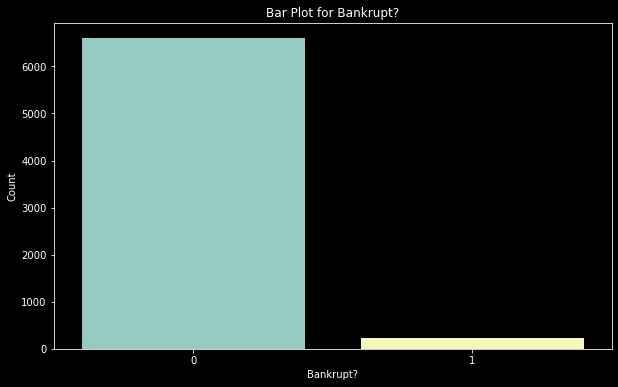

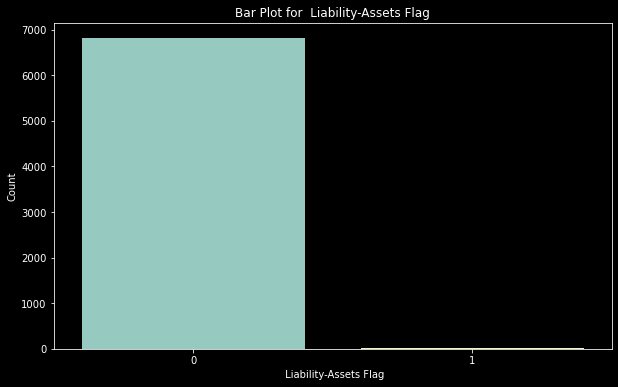

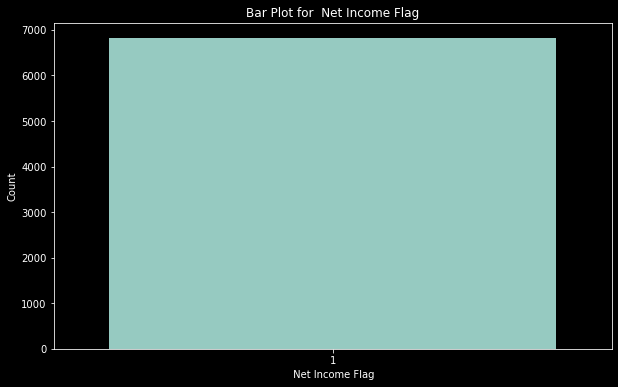

In [18]:
for col in cat_cols:
    plt.figure(figsize=(10, 6))  # Adjust the size of the plot as needed
    sns.countplot(data=df, x=col)
    plt.title(f'Bar Plot for {col}')
    plt.ylabel('Count')
    plt.xlabel(col)
    plt.show()

In [19]:
df[df[' Liability-Assets Flag']==1]['Bankrupt?'].value_counts(normalize = True)

1    0.75
0    0.25
Name: Bankrupt?, dtype: float64

Distribution of target variable can show imbalance Net Income Flagseems to be not useful.

In [20]:
cat_cols = cat_cols.drop(' Net Income Flag')

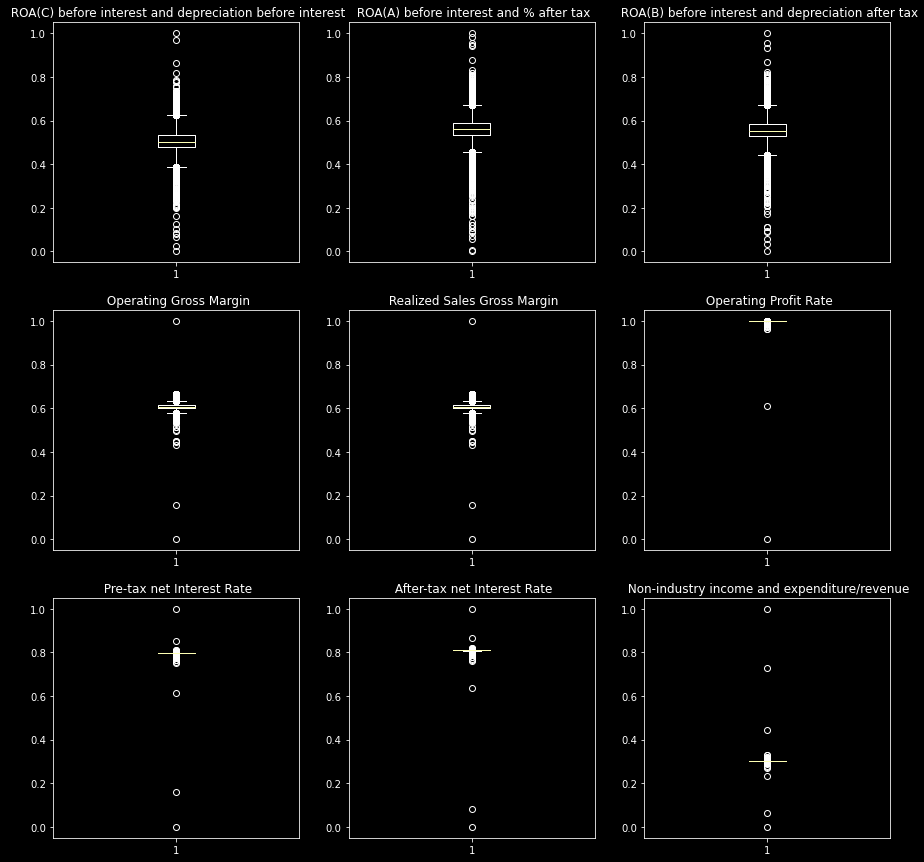

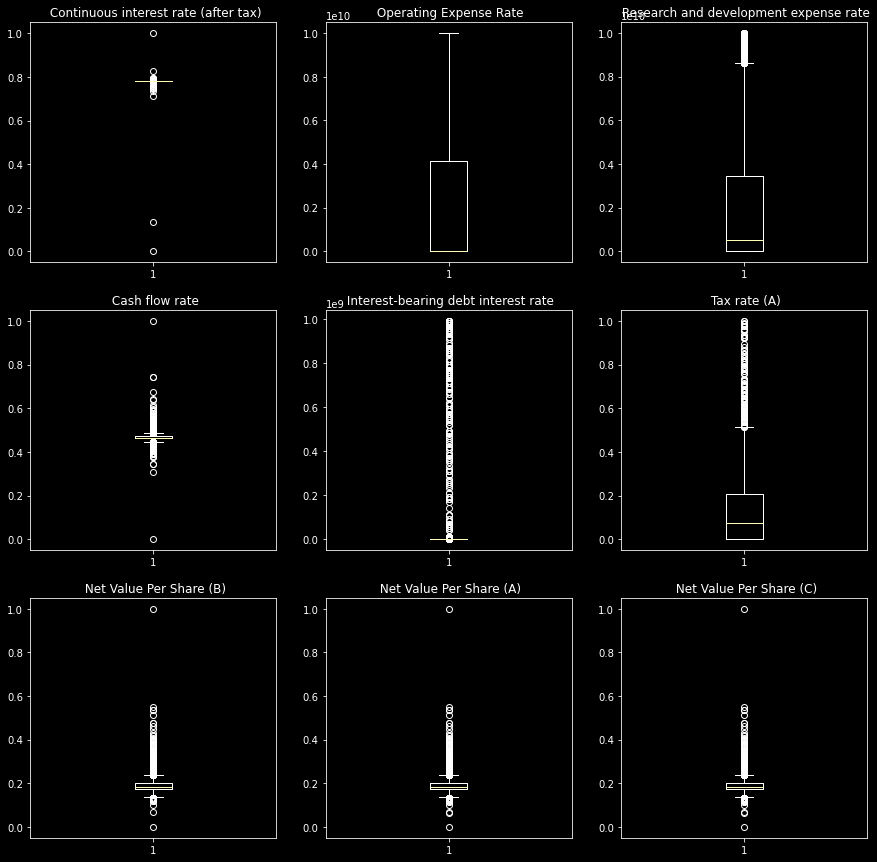

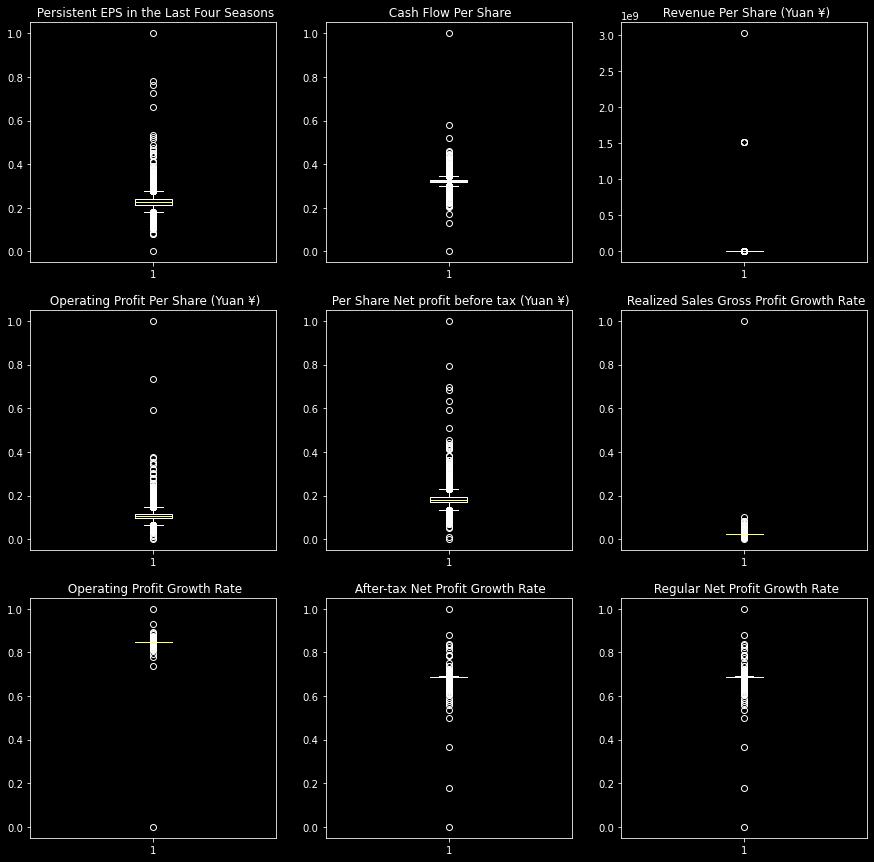

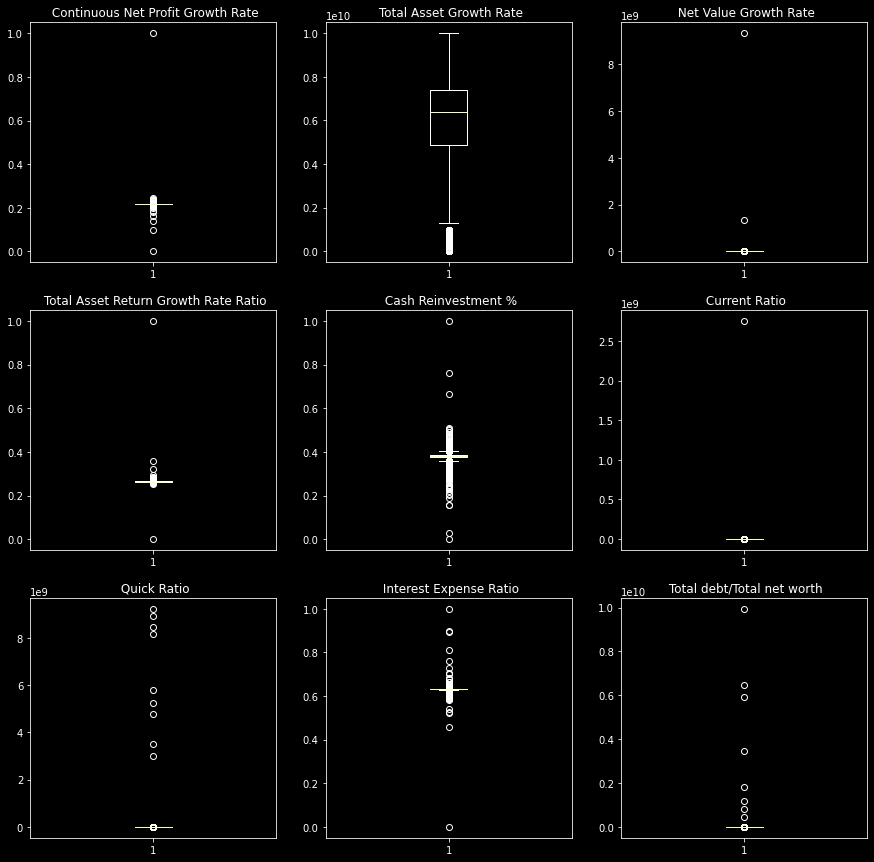

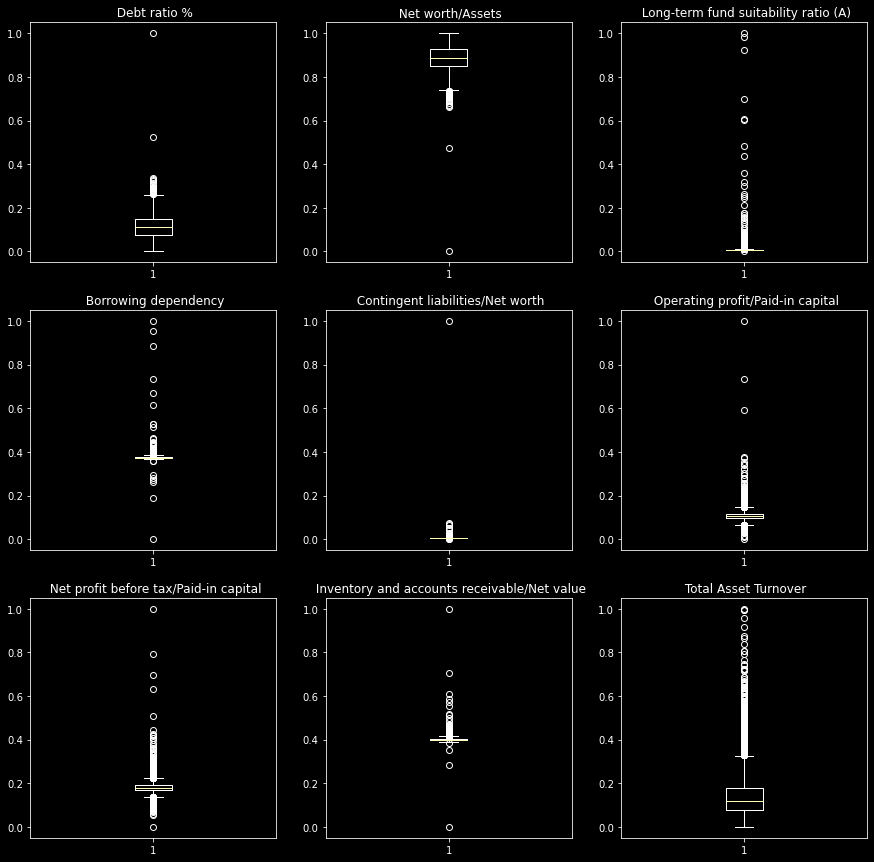

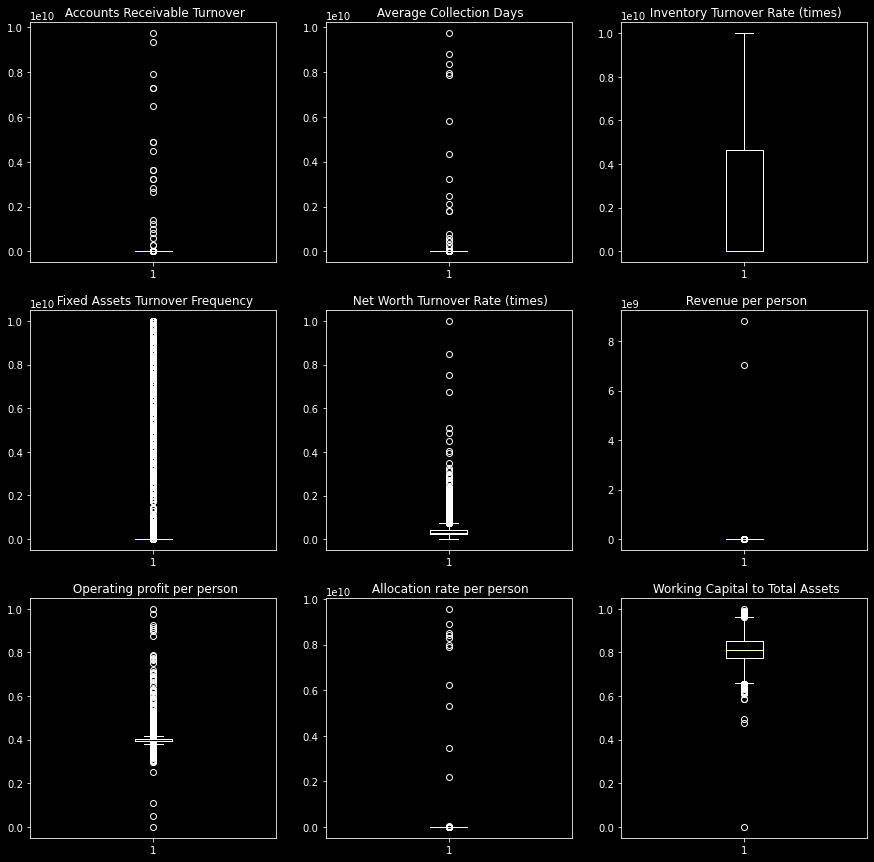

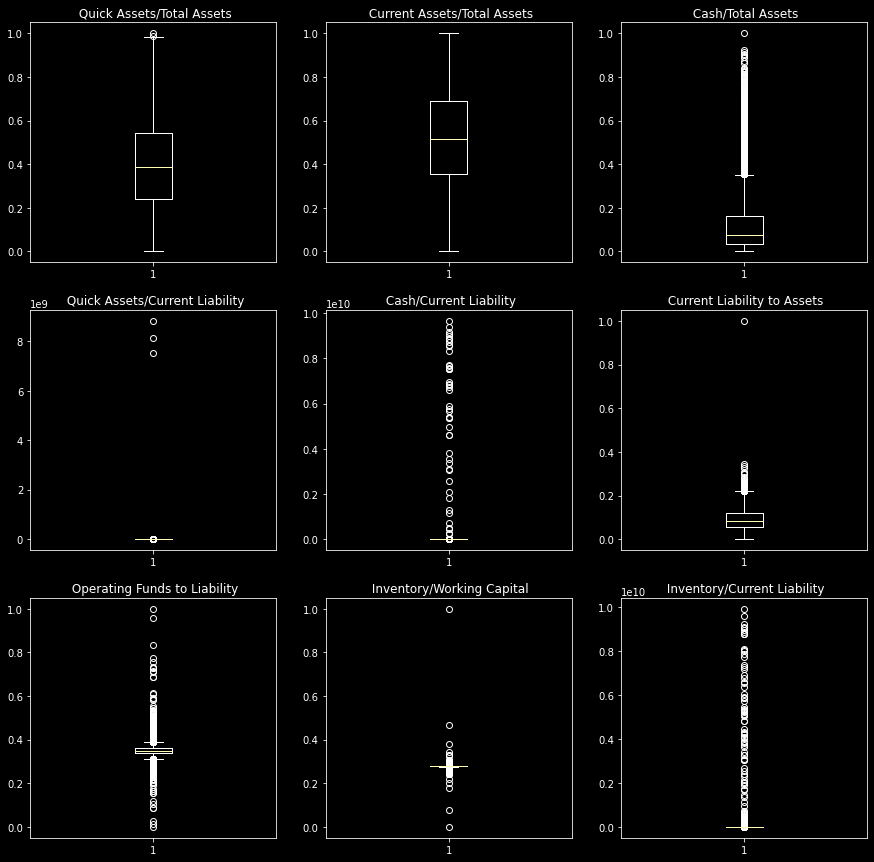

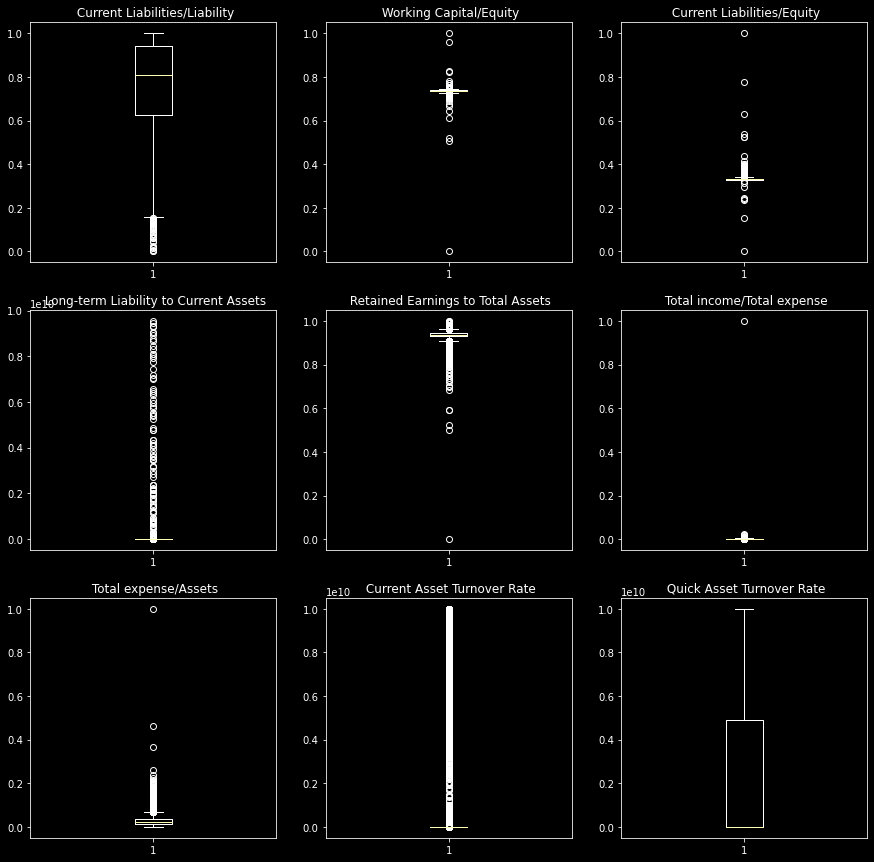

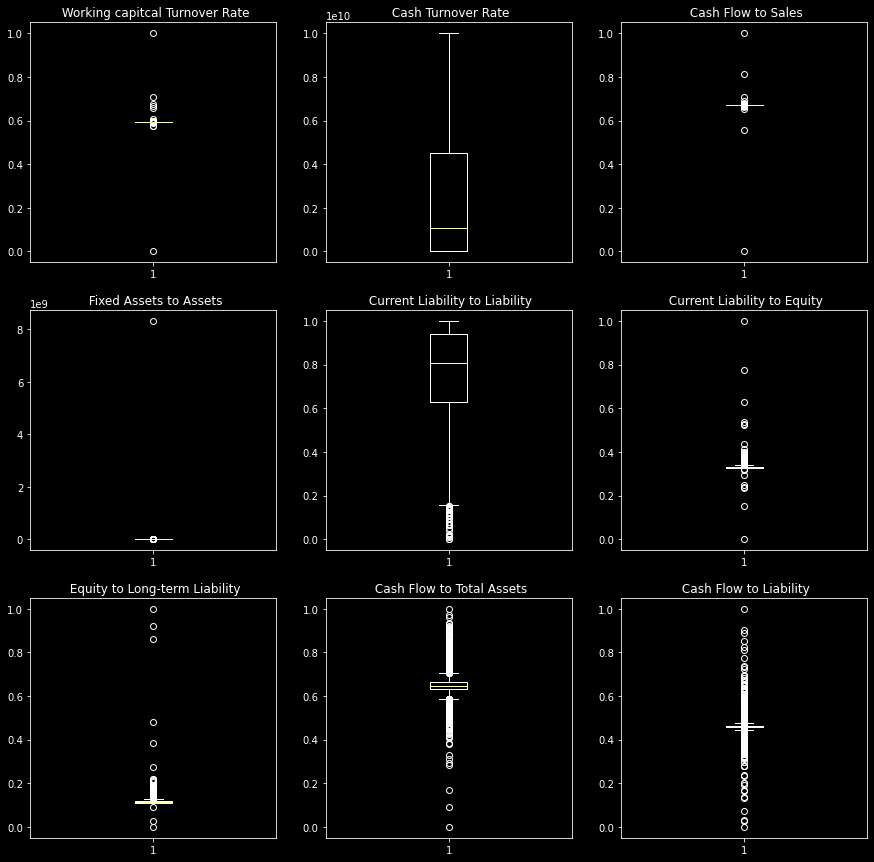

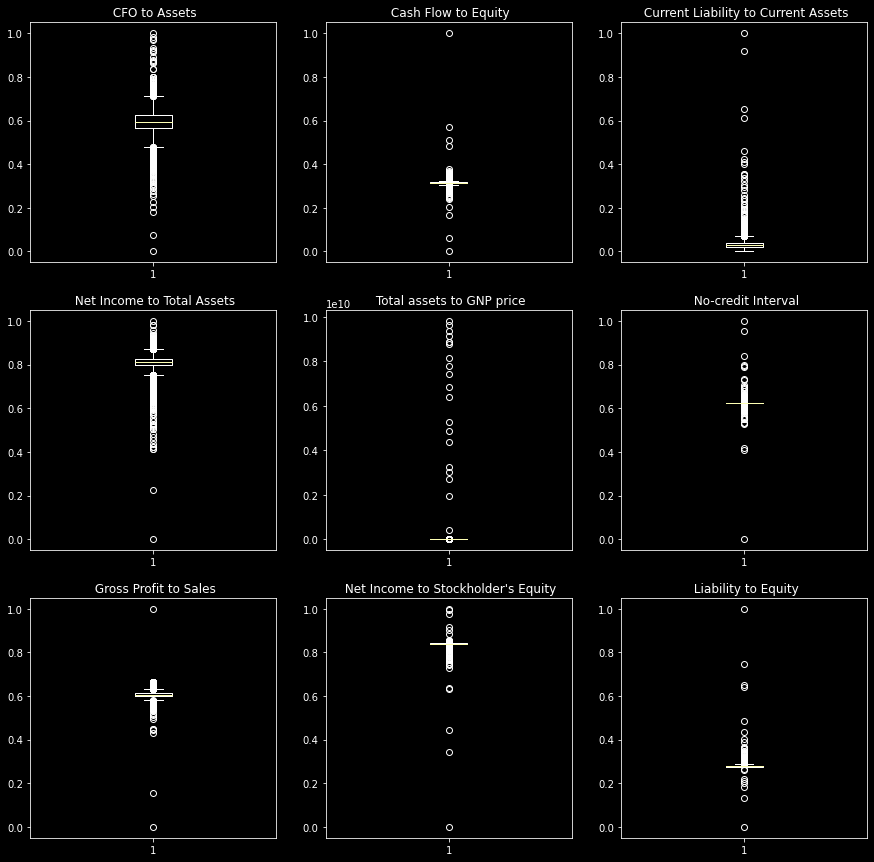

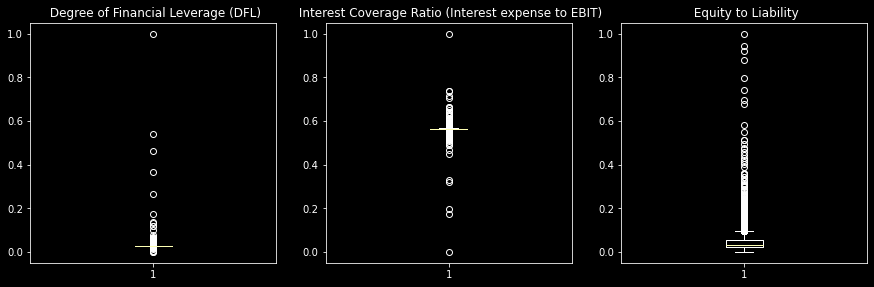

In [21]:
# Number of subplots per figure
n_cols = 3
n_rows = 3

# Loop through variables and create boxplots
for i in range(0, len(num_cols), n_cols * n_rows):
    plt.figure(figsize=(15, 15))
    for j, var in enumerate(num_cols[i:i + n_cols * n_rows]):
        plt.subplot(n_rows, n_cols, j + 1)
        plt.boxplot(df[var])
        plt.title(var)
    plt.show()

Boxplots succinctly visualize the central tendency, spread, and outliers of a dataset, highlighting the median, interquartile range, and potential anomalies

## cutting outliers

In [22]:
df_std, ratio_std, outliers = Standard_Outlier_Remover(df, num_cols, 3)
print(f"Ratio of Outliers by Standard_Outlier_Remover:{ratio_std}")

Ratio of Outliers by Standard_Outlier_Remover:28.01


## correlation 

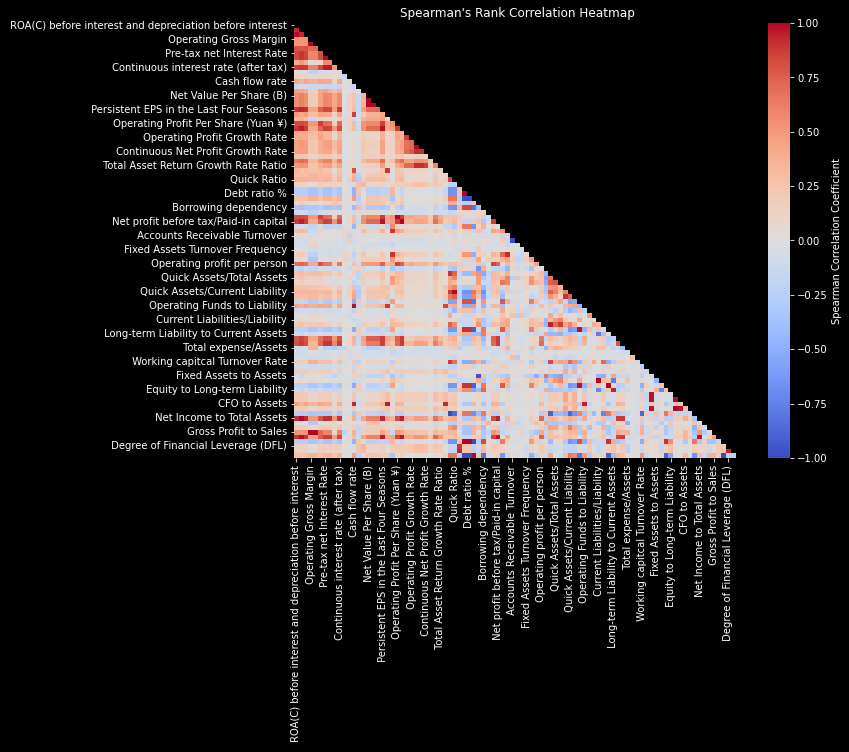

In [23]:
corr_values = heatmap_spearman_significance(df_std[num_cols], annot = False)

In [24]:
corr_values.sort_values('P-value', ascending = False)

,Correlation,P-value
Pair,,
Fixed Assets Turnover Frequency- After-tax Net Profit Growth Rate,-0.000022,0.998775
After-tax Net Profit Growth Rate- Fixed Assets Turnover Frequency,-0.000022,0.998775
Cash Reinvestment %- Interest Expense Ratio,0.000064,0.996439
Interest Expense Ratio- Cash Reinvestment %,0.000064,0.996439
Working Capital/Equity- Current Liability to Assets,-0.000163,0.990872
...,...,...
Interest Expense Ratio- Degree of Financial Leverage (DFL),0.897495,0.000000
Interest Expense Ratio- Interest Coverage Ratio (Interest expense to EBIT),0.942776,0.000000
Total debt/Total net worth- Current Ratio,-0.662888,0.000000


Some variables are highly correlated and need to be removed to avoid multicollinearity. It could lead to biased estimators, inflated standard errors, overfitting and issues with fitting process.

In [25]:
to_remove = high_corr(df[num_cols])

C:\Users\Pavilion\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Pavilion\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [26]:
num_cols_cut = num_cols.difference(to_remove)

In [27]:
df_cut = df[num_cols_cut]

After omitting highly correlated variables the number of columns decreased from 93 to 39. With two categorical variables the total number is 41.

In [28]:
final_df = pd.concat([df_cut, df[cat_cols]], axis=1).dropna()
final_df.head()

,Accounts Receivable Turnover,Allocation rate per person,Average Collection Days,Borrowing dependency,Cash Flow to Sales,Cash Reinvestment %,Cash Turnover Rate,Cash/Current Liability,Cash/Total Assets,Contingent liabilities/Net worth,Current Asset Turnover Rate,Current Assets/Total Assets,Current Liabilities/Liability,Current Liability to Assets,Current Liability to Liability,Degree of Financial Leverage (DFL),Equity to Long-term Liability,Fixed Assets Turnover Frequency,Fixed Assets to Assets,Interest-bearing debt interest rate,Inventory Turnover Rate (times),Inventory and accounts receivable/Net value,Inventory/Current Liability,Inventory/Working Capital,Long-term Liability to Current Assets,Long-term fund suitability ratio (A),Net Value Growth Rate,Net Value Per Share (C),No-credit Interval,Non-industry income and expenditure/revenue,Operating Expense Rate,Operating Profit Growth Rate,Operating profit per person,Quick Asset Turnover Rate,Quick Assets/Total Assets,Quick Ratio,Realized Sales Gross Margin,Realized Sales Gross Profit Growth Rate,Research and development expense rate,Retained Earnings to Total Assets,Revenue Per Share (Yuan ¥),Revenue per person,Tax rate (A),Total Asset Growth Rate,Total Asset Return Growth Rate Ratio,Total assets to GNP price,Total expense/Assets,Working Capital/Equity,Working capitcal Turnover Rate,Bankrupt?,Liability-Assets Flag
0,0.001814,0.037135,0.003487,0.390284,0.671568,0.363725,4.580000e+08,1.473360e-04,0.004094,0.006479,7.010000e+08,0.190643,0.676269,0.147308,0.676269,0.026601,0.126549,1.165007e-04,0.424206,0.000725,1.820926e-04,0.398036,0.001036,0.276920,0.025592,0.005024,0.000327,0.147950,0.622879,0.302646,1.256969e-04,0.848195,0.392913,6.550000e+09,0.166673,0.001208,0.601457,0.022102,0.0,0.903225,0.017560,0.034164,0.0,4.980000e+09,0.263100,0.009219,0.064856,0.721275,0.593831,1,0
1,0.001286,0.012335,0.004917,0.376760,0.671570,0.376709,2.490000e+09,1.383910e-03,0.014948,0.005835,1.065198e-04,0.182419,0.308589,0.056963,0.308589,0.264577,0.120916,7.190000e+08,0.468828,0.000647,9.360000e+09,0.397725,0.005210,0.289642,0.023947,0.005059,0.000443,0.182251,0.623652,0.303556,2.897851e-04,0.848088,0.391590,7.700000e+09,0.127236,0.004039,0.610235,0.022080,0.0,0.931065,0.021144,0.006889,0.0,6.110000e+09,0.264516,0.008323,0.025516,0.731975,0.593916,1,0
2,0.001495,0.141016,0.004227,0.379093,0.671571,0.368913,7.610000e+08,5.340000e+09,0.000991,0.006562,1.791094e-03,0.602806,0.446027,0.098162,0.446027,0.026555,0.117922,2.650000e+09,0.276179,0.000790,6.500000e+07,0.406580,0.013879,0.277456,0.003715,0.005100,0.000396,0.193713,0.623841,0.302035,2.361297e-04,0.848094,0.381968,1.022676e-03,0.340201,0.005348,0.601364,0.022760,25500000.0,0.909903,0.005944,0.028997,0.0,7.280000e+09,0.264184,0.040003,0.021387,0.742729,0.594502,1,0
3,0.001966,0.021320,0.003215,0.379743,0.671519,0.384077,2.030000e+09,1.010646e-03,0.018851,0.005366,8.140000e+09,0.225815,0.615848,0.098715,0.615848,0.026697,0.120760,9.150000e+09,0.559144,0.000449,7.130000e+09,0.397925,0.003540,0.276580,0.022165,0.005047,0.000382,0.154187,0.622929,0.303350,1.078888e-04,0.848005,0.378497,6.050000e+09,0.161575,0.002896,0.583541,0.022046,0.0,0.906902,0.014368,0.015463,0.0,4.880000e+09,0.263371,0.003252,0.024161,0.729825,0.593889,1,0
4,0.001449,0.023988,0.004367,0.375025,0.671563,0.379690,8.240000e+08,6.804636e-04,0.014161,0.006624,6.680000e+09,0.358380,0.975007,0.110195,0.975007,0.024752,0.110933,2.935211e-04,0.309555,0.000686,1.633674e-04,0.400079,0.004869,0.287913,0.000000,0.005303,0.000439,0.167502,0.623521,0.303475,7.890000e+09,0.848258,0.394371,5.050000e+09,0.260330,0.003727,0.598783,0.022096,0.0,0.913850,0.029690,0.058111,0.0,5.510000e+09,0.265218,0.003878,0.026385,0.732000,0.593915,1,0


## train-test split

In [29]:
X_train, X_test, y_train, y_test= train_test_split(final_df.drop("Bankrupt?", axis=1),
                                                   final_df["Bankrupt?"],test_size=0.1, random_state=SEED,
                                                   stratify = final_df["Bankrupt?"])

Taking into consideration the size of the dataset - 10% of the data is assigned to test the model 

## scaling

In [30]:
num_cols_new = df_cut.select_dtypes(include=['float64']).columns

scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train[num_cols_new])
X_test_std = scaler.transform(X_test[num_cols_new])

In [31]:
X_train_scaled_df = pd.DataFrame(X_train_std, columns=num_cols_new)
X_test_scaled_df = pd.DataFrame(X_test_std, columns=num_cols_new)

# Concatenating scaled and categorical data
X_train_final = pd.concat([X_train_scaled_df, X_train[cat_cols[1:]].reset_index(drop=True)], axis=1)
X_test_final = pd.concat([X_test_scaled_df, X_test[cat_cols[1:]].reset_index(drop=True)], axis=1)

In [32]:
X_test_final.shape, X_train_final.shape

((682, 50), (6137, 50))

## Synthetic Minority Over-sampling Technique

As the target variable is highly imbalanced, the SMOTE technique is used to fix this issue

In [33]:
smote= SMOTE(sampling_strategy='minority', random_state=SEED)
X_train_smote, y_train_smote= smote.fit_resample(X_train_final, y_train)

In [34]:
y_train_smote.value_counts(normalize = True)

0    0.5
1    0.5
Name: Bankrupt?, dtype: float64

# Model implementation

In [35]:
model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state = SEED)
model.fit(X_train_smote, y_train_smote)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=23)

'class_weight' can help by adjusting the weights of classes inversely proportional to their frequencies in the input data. This encourages the model to pay more attention to the minority class during training.

## model asessment

In [36]:
model.score(X_train_smote, y_train_smote)

0.8790200370432733

In [37]:
y_pred = model.predict(X_test_final)
accuracy_score(y_test, y_pred)

0.8680351906158358

In [38]:
pd.crosstab(y_pred, y_test, colnames=['Prediction'], rownames=['True'])

Prediction,0,1
True,,
0,575,5
1,85,17


In [39]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.87      0.93       660
           1       0.17      0.77      0.27        22

    accuracy                           0.87       682
   macro avg       0.58      0.82      0.60       682
weighted avg       0.96      0.87      0.91       682



The model is producing a relatively high number of false negatives. By default, the decision threshold is set at 0.5. Adjusting the threshold to classify an instance as positive can reduce false negatives but may increase false positives.

## tunning

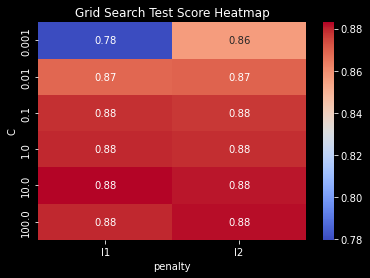

In [40]:
#GridSearch

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED) 
grid_search = GridSearchCV(LogisticRegression(random_state = SEED, max_iter = 1000), param_grid, cv=cv, scoring='accuracy',
                          n_jobs = -1)
grid_search.fit(X_train_smote, y_train_smote)

plot_grid_search(grid_search.cv_results_, ['C', 'penalty'])

To improve model's performace on test data regularization can be useful. This feature is helpful against overfitting by adding some random error to estimates. 'penalty' is used to choose the method of regularization, while 'C' is used to adjust the magnitude of regularization.

From the previous heatmap is was not 100% clear what 'C' paramter is better, so the lineplot can provide a better evidence. 

C:\Users\Pavilion\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Pavilion\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


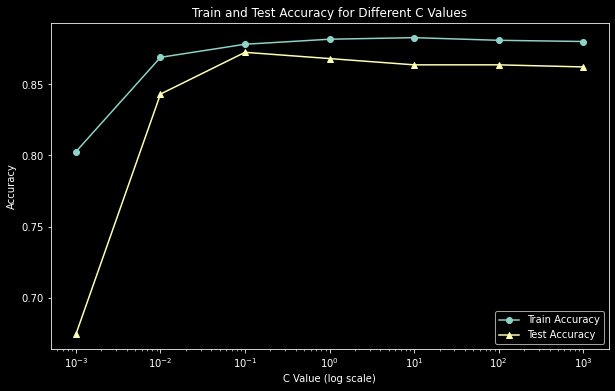

In [41]:
C_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
C_acc = grid_log_c(X_train_smote, y_train_smote, X_test_final, y_test, C_values)

In [42]:
grid_search.best_params_

{'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}

# Feature importance

## Lasso

In [43]:
# Create a logistic regression object with an L1 penalty
logistic_l1 = LogisticRegression(penalty='l1', solver='liblinear', C=0.1,\
                                max_iter=1000, class_weight='balanced', random_state = SEED)

# Fit the model
logistic_l1.fit(X_train_smote, y_train_smote)

# Get the model's performance
print(f"Train accuracy: {logistic_l1.score(X_train_smote, y_train_smote):.3f}")
print(f"Test accuracy: {logistic_l1.score(X_test_final, y_test):.3f}")

Train accuracy: 0.878
Test accuracy: 0.872


'l1' penalty can be used for feature selection as it can change the coeficients to 0 flagging totally not important features.

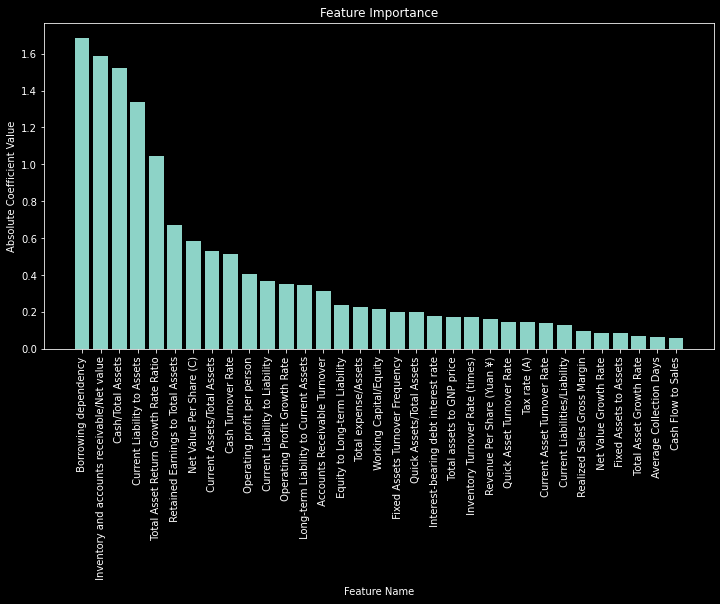

In [44]:
feature_df, low_imp_df = feature_importance_logreg(logistic_l1, X_train_smote, y_train_smote, cut_off = 0.05)

For the purpose of current analysis independent variables with coefficients less than +-0.05 are consideted as not important

In [45]:
low_imp_df

,Omitted Feature,Omitted Importance
0,No-credit Interval,0.039661
1,Non-industry income and expenditure/revenue,0.037413
2,Cash Reinvestment %,0.031368
3,Inventory/Current Liability,0.027477
4,Allocation rate per person,0.026859
5,Quick Ratio,0.026201
6,Degree of Financial Leverage (DFL),0.020230
7,Operating Expense Rate,0.017641
8,Cash/Current Liability,0.001531
9,Revenue per person,0.000000


## Statmodels

Statmodels packege can be used for logistic regression as well, providing some additional output. 

In [52]:
stat_model = sm.Logit(y_train_smote, X_train_smote)

In [53]:
result = stat_model.fit(maxiter=1000)

C:\Users\Pavilion\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


         Current function value: inf
         Iterations: 1000


C:\Users\Pavilion\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


LinAlgError: Singular matrix

In [ ]:
display(result.summary())
accuracy = np.mean(y_pred == y_test)
print('Accuracy:', accuracy)

The logit model has found the optimal parameters. 

Pseudo R-squareduggests that approximately 34.35% of the variability in the dependent variable can be explained by the model.

Likelihood ratio test suggesting that the predictors in the model are statistically significant in explaining the variability in the dependent variable.

In [ ]:
p_values = result.pvalues
high_pvalues = p_values[p_values > 0.05].index.to_list()
high_pvalues

Variables with p-values less than 0.05 are considered as not significant.

## Feature selection

In [ ]:
to_delete = set(high_pvalues + low_imp_df['Omitted Feature'].to_list())
logistic_l2 = LogisticRegression(penalty='l2', solver='liblinear', C=0.1, random_state = SEED)

acc_df, acc_delete = plot_omitted_accuracy(logistic_l2, X_train_smote, y_train_smote, X_test_final, y_test, high_pvalues, low_imp_df, SEED=SEED)

From the first plot an individual impact of omitting a single variable can be observed. Then the variables are sorted by test_acc in descending order and removed one by one to assess cumulative effect. Based on the second plot the maximum test_acc is taken and the set of variables to the ledt from the red line is removed from the data as insignificant for prediction process.

In [ ]:
X_train_fe = X_train_smote.drop(columns = acc_delete)
X_test_fe = X_test_final.drop(columns = acc_delete)
print('Train df shape ', X_train_fe.shape)
print('Test df shape ', X_test_fe.shape)

# Final model assessment 

## Implementing the model with final data

In [ ]:
# Create a logistic regression object with an L2 penalty
logistic_l2 = LogisticRegression(penalty='l2', solver='liblinear', C=0.1,\
                                max_iter=1000, class_weight='balanced', random_state = SEED)

# Fit the model
logistic_l2.fit(X_train_fe, y_train_smote)

#Predict
y_pred = logistic_l2.predict(X_test_fe)
y_pred_proba = logistic_l2.predict_proba(X_test_fe)[:,1]

# Get the model's performance
print(f"Train accuracy: {logistic_l2.score(X_train_fe, y_train_smote):.3f}")
print(f"Test accuracy: {accuracy_score(y_test, y_pred):.3f}")

Accuracy for test data is 89.6%, while train accuracy is 87.8%. The data is well-fit

## Confusion matrix and metrics

In [ ]:
pd.crosstab(y_pred, y_test, colnames=['Prediction'], rownames=['True'])

In [ ]:
print(classification_report(y_test, y_pred))

For credit scoring it is important to decide the the main strategy for a bank: if it wants to minimize true positive rate and follow more conservative strategy is redit applications aproval to decline more risky clients or it has some risk appetite and the goal is to maximize false negative rate (maximize precision) and allow as many applications from good clients as possible. Here the model is quite successfull in predicting good clients, however only 20% of risky clients from test dataset were predicted correctly. Probab;y further feateure engineering and model tunning can potentially improve the results. Also, gathering more data about defaulted clients can increase the accuracy for this group. 

## Best threshold

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
thresholds = np.clip(thresholds, 0, 1)

# Compute F1 scores for different thresholds
f1_scores = [f1_score(y_test, y_pred_proba > t) for t in thresholds]

# Identify the threshold with the maximum F1 score
best_threshold_f1 = thresholds[np.argmax(f1_scores)]

# Plotting the F1 score for each threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores, label='F1 Score')
plt.scatter(best_threshold_f1, np.max(f1_scores), color='red', label='Best threshold (F1 max)')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score across different thresholds')
plt.legend()
plt.grid(True)
plt.show()

print('Best threshold by F1-score: ', best_threshold_f1)

In [ ]:
#applying best thresold to logistic regression

y_pred_opt_f1 = (y_pred_proba > best_threshold_f1).astype(int)
display(pd.crosstab(y_pred_opt_f1, y_test, colnames=['Prediction'], rownames=['True']))
print(classification_report(y_test, y_pred_opt_f1))

With optimal threshold test accuracy increased and the classifier was able to correctly predict more companies with bankruptcy.

## ROC/AUC score

In [ ]:
plot_roc(X_test_fe, y_test, logistic_l2, 5)

Mean AUC score is 0.89 which indicates that there is a high chance that the model will be able to distinguish between the positive class and the negative class.

## Residuals distribution

In [ ]:
# Compute deviance residuals
y_log = np.log(y_pred_proba)
nlog = np.log(1 - y_pred_proba)
dev_res = np.sign(y_test - y_pred_proba) * np.sqrt(-2 * (y_test * y_log + (1 - y_test) * nlog))

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_proba, dev_res, color='blue', alpha=0.1, label='Deviance Residuals')
plt.axhline(0, color='red', linestyle='--', linewidth=1.2, label='Zero Line')
plt.xlabel('Predicted Probabilities')
plt.ylabel('Deviance Residuals')
plt.title('Deviance Residuals vs. Predicted Probabilities')
plt.legend()
plt.show()

The concentration of points around the lower probabilities with lower deviance residuals suggests that the model might be performing better at predicting the more common class (0 in this case).

In [ ]:
plt.hist(y_pred_proba, bins=20, edgecolor='black')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Probabilities')
plt.show()

In [ ]:
plt.hist(y_test, bins=2)
plt.ylabel('Count')
plt.title('Distribution of Target Variable')
plt.xlabel('Class')
plt.xticks([0,1], ha = 'right')
plt.show()

## Calibration curve

In [ ]:
prob_true, prob_pred = calibration_curve(y_test, y_pred_proba, n_bins=10, strategy='quantile')

# Plot calibration curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(prob_pred, prob_true, marker='o')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration Curve')
plt.show()

As the predicted probabilities increase, we see that the fraction of actual positives is lower than the predicted probabilities. This means the model is overconfident in its predictions; it predicts a higher probability of the positive class than what actually occurs. Also it inducates that test sample is unbalanced.

In [ ]:
brier_score_loss(y_test, y_pred_proba)

The Brier score is a metric used for evaluating the accuracy of probabilistic predictions. It is calculated as the mean squared difference between the predicted probabilities and the actual outcomes. Here the Brier score is closer to 0 than to 1, indicating relatively good accuracy in the probabilistic predictions made by the model.

## Coefficients interpretation

In [ ]:
coefficients = logistic_l2.coef_[0]  
odds_ratios = np.exp(coefficients)
feature_names = X_train_fe.columns
feature_coefficients = pd.Series(odds_ratios, index=feature_names)
feature_coefficients.sort_values(ascending = False)

Since independent variables are standardized, the coefficients relate to how many standard deviations away from the mean a feature is.  For example, a coefficient of 1.610933 for 'Borrowing dependency' means that for each one standard deviation increase in 'Borrowing dependency', the odds of bankruptcy are 61.0933% higher than the odds of not going bankrupt.

An odds ratio greater than 1 indicates that as the standardized feature increases, the odds of bankruptcy also increase.  For instance, 'Net Income to Total Assets' has an odds ratio of 0.729483, implying that a one standard deviation increase in this variable reduces the odds of bankruptcy by approximately 27.05% (since 1 - 0.729483 = 0.270517, or 27.0517%).

Odds ratios close to 1 indicate a weaker relationship with the probability of bankruptcy. For example, the 'Interest-bearing debt interest rate' has an odds ratio of approximately 0.985, suggesting a very small decrease in bankruptcy odds with an increase in this variable.

# Summary

The input data contained 6819 records for 95 features and 1 target variable.

The dimensionality of the input data was reduced from 96 to 24 variables, leaving the most important features, omitting highly correlated and insignificant ones. The most important variables are:
* net income to total assets ratio, 
* net income flag, 
* ratio of current liabilities to assets, 
* borrowing dependency. 

To solve imbalance issue SMOTE technique was utilized on training data, which was previously pre-processed to increase the quality of predictions.  

The logistic regression model was tuned by regularization parameters and achieved accuracy of 0.96, f1-score of 0.46 for the minority class (bankrupt cases) and 0.98 for the majority class (non-bankrupt cases). This indicates a moderate ability of the model to predict bankruptcy, with a better performance on the non-bankrupt cases, which is expected given the class imbalance.

Mean ROC/AUC score obtained with 5-fold cross-validation is 0.89, which is significantly better than a random predictor.